# Classification - Double-down vs Hit vs Stay 

This notebook is for model building of the classification model to predict what is the best action to take next.

<u>***Setup***</u>

In [1]:
import os,copy
import sqlite3 as sql
import numpy as np

import pandas as pd
from IPython.display import display, Math, Latex
from matplotlib import pyplot as plt

import torch as tc
from torch.utils.data.sampler import SubsetRandomSampler
import tqdm

## Pulling data

This is simply to connect to the db and pull the data to see what it looks like

In [4]:
# Specify the absolute path to the database file
db_file_path = '../data/game_state.db'

# Check if the database file exists
if os.path.exists(db_file_path):
    conn = sql.connect(db_file_path)
    hitstay_df = pd.read_sql_query('SELECT * FROM players_hitStay', conn)
else:
    print("Database file not found.")


In [5]:
print(f"{hitstay_df.shape=}")
hitstay_df.tail(20)

hitstay_df.shape=(272, 14)


,game_ID,roundNumber,player_name,player_is_pc,round_initial_bet,player_bet,game_pot,player_cards,player_hand,player_bust,house_name,house_visible_card,house_visible_hand,player_choice
252,e987a9a4-c081-4bda-8b1f-7f1fc55087f6,3,Albert,0,75.0,75.0,150,"(Sp A,Cl K)",21,0,House,Hr 4,4,stay
253,e987a9a4-c081-4bda-8b1f-7f1fc55087f6,3,PC-1,1,75.0,112.0,262,"(Hr 5,Sp K)",15,0,House,Hr 4,4,hit
254,e987a9a4-c081-4bda-8b1f-7f1fc55087f6,3,PC-1,1,75.0,112.0,262,"(Hr 5,Sp K,Cl 4)",19,0,House,Hr 4,4,stay
255,e987a9a4-c081-4bda-8b1f-7f1fc55087f6,3,House,0,75.0,0.0,262,"(Cl 6,Hr 4)",10,0,House,Hr 4,4,hit
256,e987a9a4-c081-4bda-8b1f-7f1fc55087f6,3,House,0,75.0,0.0,262,"(Cl 6,Hr 4,Hr 9)",19,0,House,Hr 9,9,stay
257,e987a9a4-c081-4bda-8b1f-7f1fc55087f6,4,Joe,0,75.0,75.0,75,"(Di K,Di 3)",13,0,House,Di 10,10,hit
258,e987a9a4-c081-4bda-8b1f-7f1fc55087f6,4,Joe,0,75.0,75.0,75,"(Di K,Di 3,Cl 2)",15,0,House,Di 10,10,hit
259,e987a9a4-c081-4bda-8b1f-7f1fc55087f6,4,Joe,0,75.0,75.0,75,"(Di K,Di 3,Cl 2,Cl 5)",20,0,House,Di 10,10,stay
260,e987a9a4-c081-4bda-8b1f-7f1fc55087f6,4,Albert,0,75.0,75.0,150,"(Sp 7,Sp A)",18,0,House,Di 10,10,stay
261,e987a9a4-c081-4bda-8b1f-7f1fc55087f6,4,PC-1,1,75.0,87.0,237,"(Di 8,Di 2)",10,0,House,Di 10,10,hit


## Analysis

Here is a quick EDA to see what the lay of the land is in the data

In [6]:
dec_grp_df = hitstay_df.groupby(['player_choice','player_is_pc']) \
    .agg(decision_count=('player_name','count')) \
        .reset_index() \
            .sort_values('decision_count',ascending=False) \
                .fillna(0)

dec_grp_df.pivot(index='player_choice',columns='player_is_pc',values='decision_count').fillna(0).head()

player_is_pc,0,1
player_choice,,
bust,27.0,6.0
double-down,25.0,0.0
hit,65.0,30.0
stay,86.0,33.0


,player_choice,player_is_pc,decision_count
5,stay,0,86
3,hit,0,65
6,stay,1,33
4,hit,1,30
0,bust,0,27
2,double-down,0,25
1,bust,1,6


<Axes: xlabel='player_choice'>

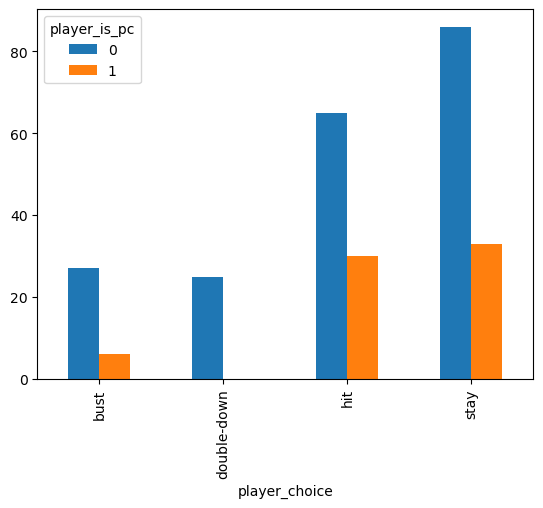

In [7]:
display(dec_grp_df.head(10))
# dec_grp_df.plot.bar(x='player_choice',y='decision_count')
dec_grp_df.pivot(index='player_choice',columns='player_is_pc',values='decision_count').fillna(0).plot.bar()


In [8]:
hitstay_df.loc[hitstay_df.player_choice == 'double-down'].head()

,game_ID,roundNumber,player_name,player_is_pc,round_initial_bet,player_bet,game_pot,player_cards,player_hand,player_bust,house_name,house_visible_card,house_visible_hand,player_choice
11,d9dfe2f1-826e-4ab1-9d40-439b2d613905,1,Albert,0,50.0,50.0,100,"(Cl A,Sp 3)",14,0,House,Sp A,11,double-down
16,d9dfe2f1-826e-4ab1-9d40-439b2d613905,2,Albert,0,50.0,100.0,200,"(Hr 6,Hr 2)",8,0,House,Sp 5,5,double-down
23,d9dfe2f1-826e-4ab1-9d40-439b2d613905,3,Joe,0,75.0,75.0,75,"(Sp 6,Hr 2)",8,0,House,Di 6,6,double-down
28,f8ee0a9c-0288-4407-86de-cc0a49531194,0,Joe,0,50.0,70.0,70,"(Hr 9,Sp 4)",13,0,House,Di 7,7,double-down
34,f8ee0a9c-0288-4407-86de-cc0a49531194,1,Albert,0,50.0,70.0,140,"(Sp 10,Di 4)",14,0,House,Cl 4,4,double-down


In [9]:
hitstay_df.loc[(hitstay_df.game_ID == 'd9dfe2f1-826e-4ab1-9d40-439b2d613905') & (hitstay_df.player_name == 'Albert')].head(10)

,game_ID,roundNumber,player_name,player_is_pc,round_initial_bet,player_bet,game_pot,player_cards,player_hand,player_bust,house_name,house_visible_card,house_visible_hand,player_choice
3,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Albert,0,50.0,70.0,140,"(Hr 2,Sp K)",12,0,House,Hr 7,7,hit
4,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Albert,0,50.0,70.0,140,"(Hr 2,Sp K,Cl J)",22,1,House,Hr 7,7,bust
11,d9dfe2f1-826e-4ab1-9d40-439b2d613905,1,Albert,0,50.0,50.0,100,"(Cl A,Sp 3)",14,0,House,Sp A,11,double-down
12,d9dfe2f1-826e-4ab1-9d40-439b2d613905,1,Albert,0,50.0,100.0,100,"(Cl A,Sp 3,Cl 7)",21,0,House,Sp A,11,stay
16,d9dfe2f1-826e-4ab1-9d40-439b2d613905,2,Albert,0,50.0,100.0,200,"(Hr 6,Hr 2)",8,0,House,Sp 5,5,double-down
17,d9dfe2f1-826e-4ab1-9d40-439b2d613905,2,Albert,0,50.0,200.0,200,"(Hr 6,Hr 2,Cl 5)",13,0,House,Sp 5,5,hit
18,d9dfe2f1-826e-4ab1-9d40-439b2d613905,2,Albert,0,50.0,200.0,200,"(Hr 6,Hr 2,Cl 5,Cl 9)",22,1,House,Sp 5,5,bust


## Data manipulation

In this section, the data to be used for classification is worked with.

The relevent data to this classification problem is:
1. `player_bet`
2. `player_cards`
3. `house_visible_card`

Initially, the classification was only binary ('**stay**' or '**hit**'), however with the addition of the '**double-down**' option, this became a multi-class problem (at least for the first decision).

I would still like to build this as a binary-classification, and use logistic regression as a base model. The reason for logisitic regression is, I would like to build the model from first principles. Then I would like to build a NN, and lastly I will include other multi-class classifiers from sklearn.

The data would be done a bit different for each step, and that is fine for then. For now only focus on the binary classification and swop the '**double-down**' option for a normal '**hit**' option.

In order to train "*good*" behavior, I will test and see if it will work to treat the pen-ultimate decision as '`stay`' if the ultimate result was a '`bust`'.

> ***NOTE***:
> 
> For the first part I will exclude the `House` from the dataset. The behavior in the logging is different for `House`. There can be a separate model developed solely for the `House`

In [20]:
select_cols = ['player_hand','house_visible_hand','house_card','player_bet','player_cards']

players_df = hitstay_df.loc[hitstay_df.player_name != 'House'].copy()
players_df['house_card'] = players_df.house_visible_card.str.split().str[1]

_, card_col_no = players_df.player_cards.str.replace("(","").str.replace(")","").str.split(",",expand=True).shape
card_cols = [f"card_{i+1}" for i in np.arange(card_col_no)]
select_cols.extend(card_cols)

players_df[card_cols] = players_df.player_cards.str.replace("(","").str.replace(")","").str.split(",",expand=True)
for col in card_cols:
    players_df[col] = players_df[col].str.split().str[1]

## Not sure if 0 is better than None. I think None will help a bit more...
# players_df[card_cols] = players_df[card_cols].fillna(value=0)

players_df[select_cols].head()

,player_hand,house_visible_hand,house_card,player_bet,player_cards,card_1,card_2,card_3,card_4,card_5
0,13,7,7,70.0,"(Di 2,Sp A)",2,A,None,None,None
1,13,7,7,70.0,"(Di 2,Sp A,Cl Q)",2,A,Q,None,None
2,18,7,7,70.0,"(Di 2,Sp A,Cl Q,Cl 5)",2,A,Q,5,None
3,12,7,7,70.0,"(Hr 2,Sp K)",2,K,None,None,None
4,22,7,7,70.0,"(Hr 2,Sp K,Cl J)",2,K,J,None,None


### Dummy columns

Dummy variables are created based on the player's cards

In [31]:
def check_and_order_columns(df,ordered_list):
    df_cols = df.columns; df_rows, _ = df.shape
    mis_cols = [c for c in ordered_list if c not in df_cols]
    if len(mis_cols) > 0:
        for mc in mis_cols:
            df[mc] = np.zeros(df_rows).astype(int)
    return (mis_cols, df[ordered_list].copy())

def create_addative_dummy_matrix(df,columns_to_dummy,dummy_columns):
    ret_df = pd.get_dummies(df[columns_to_dummy[0]]).astype(int)
    for col in columns_to_dummy[1:]:
        ret_df = ret_df.add(pd.get_dummies(df[col]),fill_value=0).astype(int)
    mis_cols,ret_df = check_and_order_columns(ret_df,dummy_columns)
    return (mis_cols,ret_df)

In [47]:
dummy_columns = ['2','3','4','5','6','7','8','9','10','J','Q','K','A']
mis_dummy_cols, dummy_df = create_addative_dummy_matrix(df=players_df, columns_to_dummy=card_cols,dummy_columns=dummy_columns)

## Adding the house_visible_card in
dummy_df = dummy_df.add(pd.get_dummies(players_df.house_card).astype(int)*-0.5, fill_value=0)
mis_dummy_cols_2, dummy_df = check_and_order_columns(dummy_df,dummy_columns)

print(f"dummy_df [{dummy_df.shape=}] ({mis_dummy_cols=}) ({mis_dummy_cols_2=})")
display(dummy_df.head())

dummy_df [dummy_df.shape=(192, 13)] (mis_dummy_cols=[]) (mis_dummy_cols_2=[])


,2,3,4,5,6,7,8,9,10,J,Q,K,A
0,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,-0.5,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [46]:
## Just checking the additions
dummy_df.join(players_df[['house_card','player_cards',*card_cols]],how='left').head()

,2,3,4,5,6,7,8,9,10,J,Q,K,A,house_card,player_cards,card_1,card_2,card_3,card_4,card_5
0,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,"(Di 2,Sp A)",2,A,None,None,None
1,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,1.0,0.0,1.0,7,"(Di 2,Sp A,Cl Q)",2,A,Q,None,None
2,1.0,0.0,0.0,1.0,0.0,-0.5,0.0,0.0,0.0,0.0,1.0,0.0,1.0,7,"(Di 2,Sp A,Cl Q,Cl 5)",2,A,Q,5,None
3,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7,"(Hr 2,Sp K)",2,K,None,None,None
4,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,7,"(Hr 2,Sp K,Cl J)",2,K,J,None,None
